In [1]:
import glob 
import tables
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy import stats
from astropy import units as u
from astropy.coordinates import SkyCoord

TSUN = 4.9169e-6
PC = 3.0856775807e16
CLIGHT = 299792458.

catalog_columns = ['f','colatitude','longitude','amplitude','inclination','polarization','phase','fdot','fddot','sigma_df/f','sigma_colatitude','sigma_longitude','sigma_dA/A','sigma_inclination','sigma_polarization','sigma_phase','sigma_dfdot/fdot','sigma_dfddot/fddot','sigma_Omega','SNR']
output_columns = catalog_columns + ['b','l','mchirp','distance']

In [2]:
# # Import raw gbfisher data
# catalog = pd.read_table('SigmasAE.dat',delimiter=' ', header=None,index_col=False,names=catalog_columns)

# # Convert to galactic coordinates
# def ecliptic_to_galactic(row):

#     ecl_lon = row[2]*u.rad
#     ecl_lat = (np.pi/2 - row[1])*u.rad

#     gal = SkyCoord(ecl_lon,ecl_lat,frame='barycentrictrueecliptic').galactic
    
#     gal_lon = gal.l.degree
#     gal_lat = gal.b.degree
    
#     return pd.Series(dict(l=gal_lon,b=gal_lat))

# #catalog['b']=catalog.apply(lambda row: SkyCoord(catalog.longitude*u.rad,(np.pi/2 - catalog.colatitude)*u.rad,frame='barycentrictrueecliptic').galactic.b.degree, axis=1)
# catalog = catalog.join(catalog.apply(lambda row: ecliptic_to_galactic(row), axis=1))

# # Get chirp masses and distances (not sure how to get uncertainties on these)
# def amp_to_distance(row):
    
#     f = row[0]
#     A = row[3]
#     fdot = row[7]

#     Mc = 0
#     DL = 0
#     if(fdot>0):
#         Mc = (( fdot * (5./96.) / np.pi**(8./3.) / f**(11./3.))**(3./5.))/TSUN
#         DL = ((5./48.)*(fdot/(np.pi**2*f**3*A))*CLIGHT/PC)
    
#     return pd.Series(dict(mchirp=Mc,distance=DL))

# catalog = catalog.join(catalog.apply(lambda row: amp_to_distance(row), axis=1))

# # remove the binaries with unknown distance (and by extension unknown fdot and chirp mass too)   
# rem = catalog['distance'].between(0.0,0.001)
# catalog = catalog.drop(catalog.index[rem],axis=0)

# catalog.head()

# # Create gbfisher checkpoint file for speeding up data analysis
# gbfisher = pd.DataFrame(columns = output_columns)
# for col_name in output_columns:
#     gbfisher[col_name] = catalog[col_name]
# gbfisher.to_csv('gbfisher_checkpoint.dat',sep=' ',header=None,index=False)

In [3]:
# Import gbfisher data
catalog = pd.read_table('gbfisher_checkpoint.dat',delimiter=' ', header=None,index_col=False,names=output_columns)
catalog.head()

,f,colatitude,longitude,amplitude,inclination,polarization,phase,fdot,fddot,sigma_df/f,...,sigma_polarization,sigma_phase,sigma_dfdot/fdot,sigma_dfddot/fddot,sigma_Omega,SNR,b,l,mchirp,distance
0,0.000167,0.954373,3.954100,1.161330e-21,0.584423,2.811940,4.50278,3.934090e-21,3.402775e-37,1.146358e-09,...,4.038658,8.090218,2319.0080,-2.038056e+35,387.10050,7.325647,50.753900,26.979350,0.647315,74.887180
1,0.000212,1.514540,0.837797,1.367850e-21,2.893390,0.106658,4.17682,1.681630e-20,4.891866e-36,5.236547e-10,...,62.699350,125.403700,241.8305,-2.589325e+45,77.28670,16.531061,-33.496950,159.194534,0.913186,132.378587
2,0.000219,0.753700,0.679597,1.248440e-21,0.944777,0.057978,4.82894,1.418480e-20,3.361257e-36,9.178591e-10,...,0.382849,0.809264,489.7364,-4.787731e+55,187.96540,9.833322,-5.709033,121.980912,0.763601,110.180909
3,0.000227,2.555120,2.771070,2.011320e-21,1.401630,0.017058,4.35799,7.452880e-21,8.971106e-37,8.849340e-10,...,0.136491,0.310786,917.8140,-3.316872e+66,160.32200,9.992462,1.918278,264.805670,0.481860,32.472901
4,0.000228,2.314790,5.137680,2.022570e-21,2.573180,0.387113,5.68457,2.339130e-20,8.783644e-36,3.864640e-10,...,1.465059,2.931015,122.3382,-2.346923e+76,34.10879,23.505228,-36.862214,333.292859,0.944428,99.525353


In [4]:
# Compute "luminosity"
catalog['luminosity'] = 1/(catalog['distance']**2)
catalog['luminosity'] = catalog['luminosity'] / sum(catalog['luminosity'])

# remove binaries with bad luminosity values (maybe look into this issue)
catalog = catalog.dropna(subset=['luminosity'])

In [5]:
# Compute KDE
coords = np.vstack([catalog['l'],catalog['b']])
kernel = stats.gaussian_kde(coords)
kde = kernel.evaluate(coords).T / sum(kernel.evaluate(coords).T)

# take logarithm to weaken the influence of KDE over binary selection
catalog['KDE'] = pd.Series(-np.log(kde))

In [6]:
# Primitive weighting algorithm
ckde = 1
csnr = 2
clum = 1

catalog['weight'] = (catalog['KDE']**ckde)*(catalog['SNR']**csnr)*(catalog['luminosity']**clum)
catalog['weight'] = catalog['weight'] / sum(catalog['weight'])

catalog.head()

,f,colatitude,longitude,amplitude,inclination,polarization,phase,fdot,fddot,sigma_df/f,...,sigma_dfddot/fddot,sigma_Omega,SNR,b,l,mchirp,distance,luminosity,KDE,weight
0,0.000167,0.954373,3.954100,1.161330e-21,0.584423,2.811940,4.50278,3.934090e-21,3.402775e-37,1.146358e-09,...,-2.038056e+35,387.10050,7.325647,50.753900,26.979350,0.647315,74.887180,0.011625,16.860476,0.000036
1,0.000212,1.514540,0.837797,1.367850e-21,2.893390,0.106658,4.17682,1.681630e-20,4.891866e-36,5.236547e-10,...,-2.589325e+45,77.28670,16.531061,-33.496950,159.194534,0.913186,132.378587,0.003720,16.014254,0.000056
2,0.000219,0.753700,0.679597,1.248440e-21,0.944777,0.057978,4.82894,1.418480e-20,3.361257e-36,9.178591e-10,...,-4.787731e+55,187.96540,9.833322,-5.709033,121.980912,0.763601,110.180909,0.005370,13.031887,0.000023
3,0.000227,2.555120,2.771070,2.011320e-21,1.401630,0.017058,4.35799,7.452880e-21,8.971106e-37,8.849340e-10,...,-3.316872e+66,160.32200,9.992462,1.918278,264.805670,0.481860,32.472901,0.061824,11.402098,0.000243
4,0.000228,2.314790,5.137680,2.022570e-21,2.573180,0.387113,5.68457,2.339130e-20,8.783644e-36,3.864640e-10,...,-2.346923e+76,34.10879,23.505228,-36.862214,333.292859,0.944428,99.525353,0.006582,16.281048,0.000204


In [7]:
# Apply cuts and plot result

weight_min = 7.55E-5  # 1.75E-4
weight_max = 1

Max_Period = 20 # minutes
f_min = 2/(60*Max_Period)
f_max = 1

sigma_incl_min= 0
sigma_incl_max= 5

cut = catalog['weight'].between(weight_min,weight_max) \
    & catalog['f'].between(f_min,f_max) \
    & np.degrees(catalog['sigma_inclination']).between(sigma_incl_min,sigma_incl_max)

catalog[cut].head(n=150)

,f,colatitude,longitude,amplitude,inclination,polarization,phase,fdot,fddot,sigma_df/f,...,sigma_dfddot/fddot,sigma_Omega,SNR,b,l,mchirp,distance,luminosity,KDE,weight
4226,0.001676,1.742900,3.21926,5.132260e-22,2.523140,0.119065,0.053879,5.349690e-18,6.261139e-32,3.963916e-11,...,-inf,0.117463,220.517232,50.098915,283.197894,0.306535,227.035211,0.001265,16.815209,0.003570
4273,0.001686,1.959690,4.18309,4.992740e-22,2.073520,2.960920,3.473620,1.841650e-17,7.375518e-31,6.207588e-11,...,-inf,0.183266,143.638979,12.539778,331.274456,0.635108,789.019939,0.000105,13.813203,0.000103
4297,0.001691,0.313511,4.12930,1.779410e-22,2.272250,1.064580,3.407180,3.240390e-18,2.277064e-32,1.506616e-10,...,-inf,0.485030,56.527459,38.339666,77.225309,0.222560,386.321022,0.000437,16.117235,0.000078
4370,0.001702,2.178700,3.48736,4.884920e-22,1.100900,0.756933,3.169840,3.349880e-18,2.417760e-32,6.524802e-11,...,-inf,0.150146,136.753106,22.718375,293.919703,0.223815,142.666142,0.003203,15.089865,0.003120
5346,0.001887,1.911840,4.39286,1.778240e-22,2.337090,2.949070,2.816580,5.008740e-18,4.874412e-32,1.040668e-10,...,-inf,0.461285,85.737590,5.210897,340.320530,0.226961,429.752804,0.000353,11.031441,0.000099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19390,0.011073,2.249550,3.25412,2.328180e-22,2.196520,1.228780,3.616340,2.638580e-15,2.305408e-27,1.287545e-11,...,-inf,0.000143,692.002213,21.037895,281.740053,0.198760,855.973898,0.000089,14.809292,0.002178
19421,0.011584,1.552620,1.26806,3.676500e-22,0.686485,2.288220,4.201460,8.009580e-15,2.030651e-26,6.186265e-12,...,-inf,0.000456,1409.205483,-14.469698,176.623936,0.350406,1437.168547,0.000032,14.608234,0.003161
19477,0.013731,0.887860,1.12272,3.053580e-22,1.328530,1.091200,1.943180,1.553160e-14,6.441558e-26,1.549446e-11,...,-inf,0.000129,581.258525,1.257521,140.745444,0.358632,2014.500186,0.000016,12.371517,0.000232
19493,0.016086,2.623190,3.87325,5.199380e-22,1.691190,2.855660,5.065210,5.687860e-14,7.374233e-25,1.161027e-11,...,-inf,0.000036,779.048213,-6.421612,295.833816,0.551648,2694.879595,0.000009,12.243839,0.000230


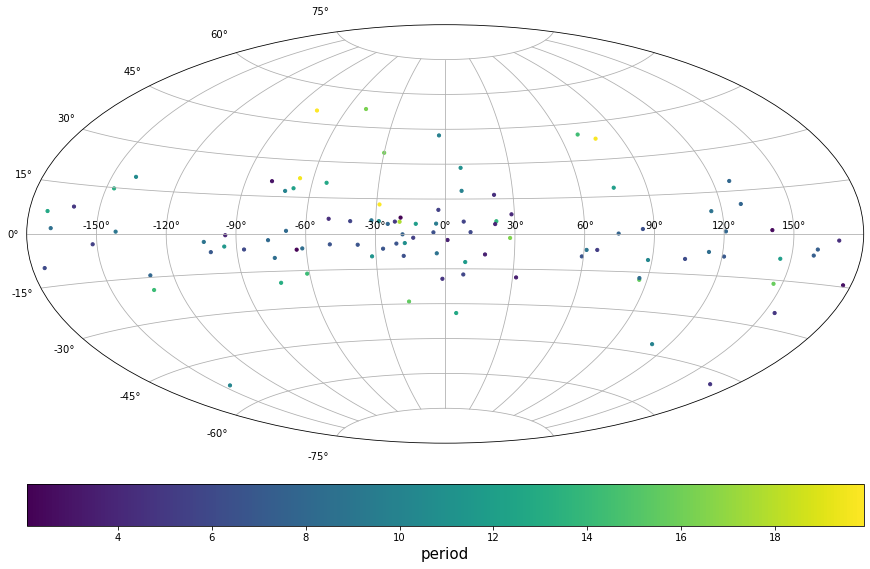

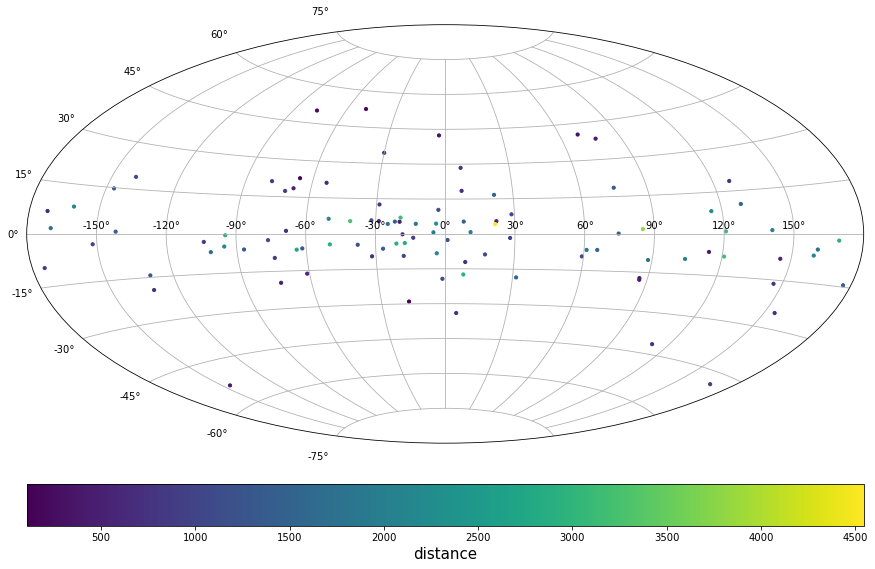

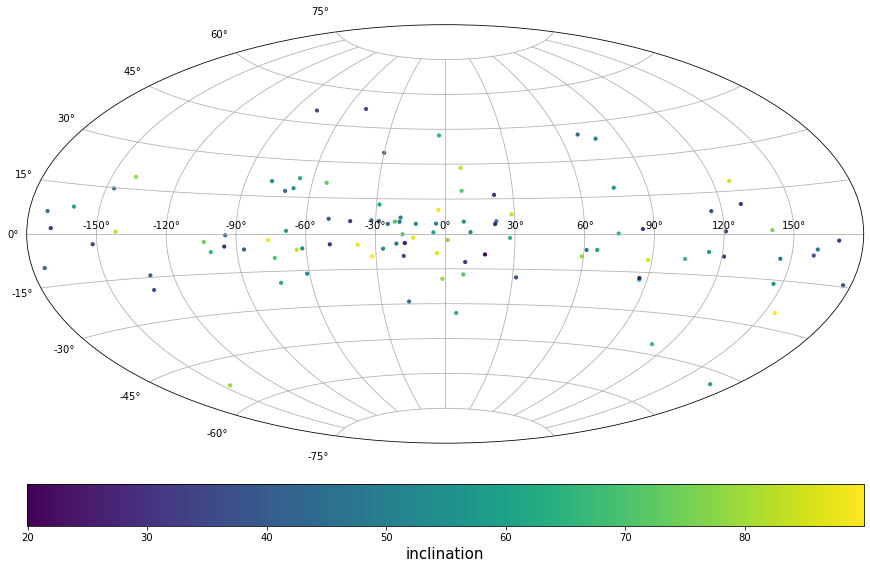

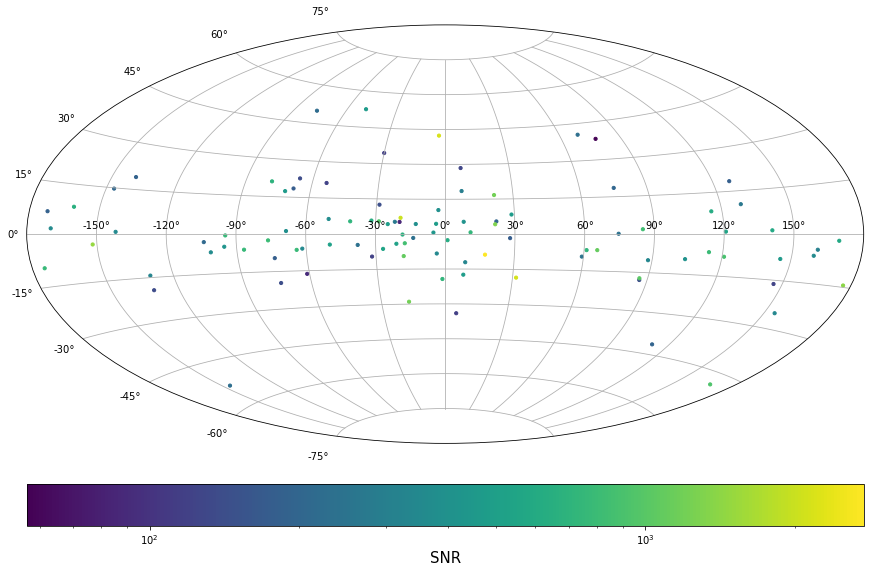

In [8]:
# sky plot showing periods
f = plt.figure(figsize=(15,15))
plt.subplot(111, projection='aitoff')
plt.grid(True)
gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,s=10,c=1/(30*catalog[cut]['f']),cmap='viridis')
cbar = plt.colorbar(orientation='horizontal',pad=0.05)
cbar.set_label(label='period',size=15)

# sky plot showing distances
f = plt.figure(figsize=(15,15))
plt.subplot(111, projection='aitoff')
plt.grid(True)
gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,s=10,c=catalog[cut]['distance'],cmap='viridis')
cbar = plt.colorbar(orientation='horizontal',pad=0.05)
cbar.set_label(label='distance',size=15)

# sky plot showing inclinations
f = plt.figure(figsize=(15,15))
plt.subplot(111, projection='aitoff')
plt.grid(True)
gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,s=10,c=90-abs(np.degrees(catalog[cut]['inclination'])-90),cmap='viridis')
cbar = plt.colorbar(orientation='horizontal',pad=0.05)
cbar.set_label(label='inclination',size=15)

# sky plot showing SNRs
f = plt.figure(figsize=(15,15))
plt.subplot(111, projection='aitoff')
plt.grid(True)
gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,s=10,c=catalog[cut]['SNR'],cmap='viridis',norm=clr.LogNorm())
cbar = plt.colorbar(orientation='horizontal',pad=0.05)
cbar.set_label(label='SNR',size=15)

In [9]:
# # Create gbmcmc input file for selected binaries
# gbmcmc_columns = ['f','fdot','colatitude','longitude','amplitude','inclination','polarization','phase']
# gbmcmc = pd.DataFrame(columns = gbmcmc_columns)
# for col_name in output_columns:
#     gbmcmc[col_name] = catalog[cut][col_name]
# gbmcmc.to_csv('Binary_Parameters.dat',sep=' ',header=None,index=False)

In [10]:
# # Create gbfisher data file for selected binaries for comparison with gwemlisa data
# output = pd.DataFrame(columns = output_columns)
# for col_name in output_columns:
#     output[col_name] = catalog[cut][col_name]
# output.to_csv('gbfisher_parameters.dat',sep=' ',header=None,index=False)